# Sharp regression discontinuity with `pymc` models

In [1]:
import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

In [3]:
df = cp.load_data("rd")

## Linear, main-effects, and interaction model

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


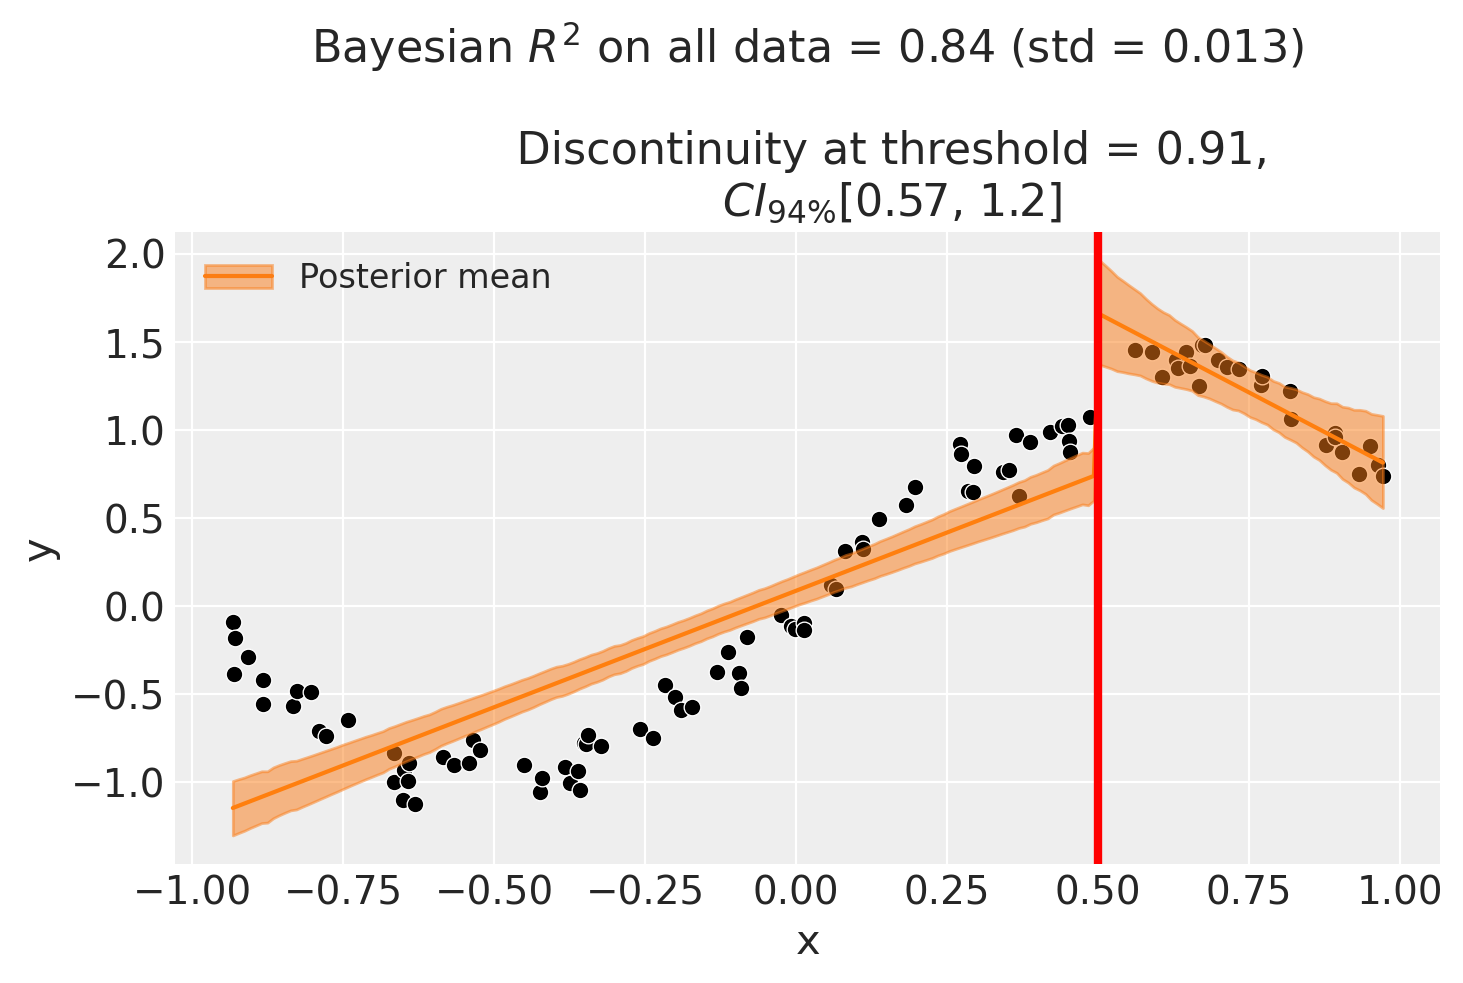

In [4]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

fig, ax = result.plot()

Though we can see that this does not give a good fit of the data almost certainly overestimates the discontinuity at threshold.

## Using a bandwidth

One way how we could deal with this is to use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the threshold. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

In [5]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

fig, ax = result.plot()

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


We could even go crazy and just fit intercepts for the data close to the threshold. But clearly this will involve more estimation error as we are using less data.

In [6]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
    bandwidth=0.2,
)

fig, ax = result.plot()

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


## Using basis splines

Though it could arguably be better to fit with a more complex model, fit example a spline. This allows us to use all of the data, and (depending on the situation) maybe give a better fit.

In [7]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

fig, ax = result.plot()

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


As with all of the models in this notebook, we can ask for a summary of the model coefficients.

In [8]:
result.summary()

Difference in Differences experiment
Formula: y ~ 1 + bs(x, df=6) + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.41$CI_{94\%}$[0.24, 0.59]


Model coefficients:
    Intercept        -0.23, 94% HDI [-0.32, -0.14]
    treated[T.True]  0.41, 94% HDI [0.24, 0.59]
    bs(x, df=6)[0]   -0.6, 94% HDI [-0.78, -0.41]
    bs(x, df=6)[1]   -1.1, 94% HDI [-1.2, -0.93]
    bs(x, df=6)[2]   0.28, 94% HDI [0.12, 0.43]
    bs(x, df=6)[3]   1.7, 94% HDI [1.5, 1.8]
    bs(x, df=6)[4]   1, 94% HDI [0.66, 1.4]
    bs(x, df=6)[5]   0.56, 94% HDI [0.36, 0.75]
    y_hat_sigma      0.1, 94% HDI [0.089, 0.12]


## Effect Summary Reporting

For decision-making, you often need a concise summary of the causal effect. The `effect_summary()` method provides a decision-ready report with key statistics. Note that for Regression Discontinuity, the effect is a single scalar (the discontinuity at the threshold), similar to Difference-in-Differences.


In [9]:
# Generate effect summary
stats = result.effect_summary()
stats.table

,mean,median,hdi_lower,hdi_upper,p_gt_0
discontinuity,0.411137,0.409325,0.239555,0.601715,1.0


In [10]:
print(stats.text)

The discontinuity at threshold was 0.41 (95% HDI [0.24, 0.60]), with a posterior probability of an increase of 1.000.


You can customize the summary with different directions and ROPE thresholds:

- **Direction**: Test for increase, decrease, or two-sided effect
- **Alpha**: Set the HDI confidence level (default 95%)
- **ROPE**: Specify a minimal effect size threshold


In [11]:
# Example: Two-sided test with ROPE
stats = result.effect_summary(
    direction="two-sided",
    alpha=0.05,
    min_effect=0.2,  # Region of Practical Equivalence
)
stats.table

,mean,median,hdi_lower,hdi_upper,p_two_sided,prob_of_effect,p_rope
discontinuity,0.411137,0.409325,0.239555,0.601715,0.0,1.0,0.99125


In [12]:
print("\n" + stats.text)


The discontinuity at threshold was 0.41 (95% HDI [0.24, 0.60]), with a posterior probability of an effect of 1.000.


## Sensitivity analysis

The validity of a regression discontinuity design hinges on two conditions: (1) the treatment effect estimate should be robust to the choice of bandwidth, and (2) units should not be able to manipulate the running variable to sort themselves across the threshold {cite:p}`imbens2008regression,lee2010regression`.

### Bandwidth sensitivity

The choice of bandwidth involves a bias–variance trade-off. A narrow bandwidth reduces bias (only very similar units are compared) but increases variance (fewer observations). A wide bandwidth reduces variance but may introduce bias if the functional form is mis-specified away from the threshold.

`BandwidthSensitivity` refits the model at several bandwidths (here 0.1, 0.25, 0.5, and 1.0) and reports the effect estimate at each. **If the estimate is stable across bandwidths**, this is evidence that the result is not an artifact of a particular bandwidth choice {cite:p}`imbens2008regression`.

### McCrary density test

A core assumption of RD is that units cannot precisely control the running variable to sort themselves to one side of the threshold. {cite:t}`mccrary2008manipulation` proposed testing this by checking whether the density of the running variable is continuous at the threshold.

The test counts observations in bins on each side of the threshold and computes a z-statistic. **A significant result** (small p-value) suggests that there are more observations on one side than expected, which may indicate manipulation and threatens the validity of the RD design.

**Interpreting the output.** The report shows: (1) a table of effect estimates at each bandwidth — look for consistency; (2) the McCrary test statistic, p-value, and bin counts. In this simulated example, the data are drawn from a known DGP, so the McCrary test may flag the artificial density imbalance built into the simulation.

In [13]:
sensitivity_result = cp.Pipeline(
    data=df,
    steps=[
        cp.EstimateEffect(
            method=cp.RegressionDiscontinuity,
            formula="y ~ 1 + x + treated + x:treated",
            model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
            treatment_threshold=0.5,
        ),
        cp.SensitivityAnalysis(
            checks=[
                cp.checks.BandwidthSensitivity(bandwidths=[0.1, 0.25, 0.5, 1.0]),
                cp.checks.McCraryDensityTest(n_bins=20),
            ],
        ),
        cp.GenerateReport(include_plots=True),
    ],
).run()

for cr in sensitivity_result.sensitivity_results:
    print(cr.text)
    print()

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


/Users/benjamv/git/CausalPy/causalpy/experiments/regression_discontinuity.py:108: UserWarning: Choice of bandwidth parameter has lead to only 8 remaining datapoints. Consider increasing the bandwidth parameter.
  self._build_design_matrices()
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


There were 203 divergences after tuning. Increase `target_accept` or reparameterize.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Bandwidth sensitivity analysis: compared 4 bandwidth values. Examine the table for consistency of effect estimates across bandwidths.

McCrary density test: possible manipulation detected at threshold 0.5 (z=5.774, p=0.000). Observations below: 75, above: 25.




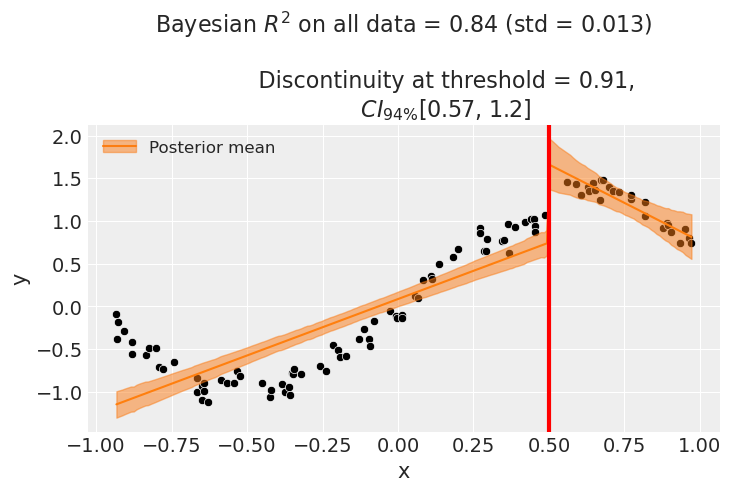

In [14]:
import html as html_module
import warnings

from IPython.display import HTML

with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore", "Consider using IPython.display.IFrame", UserWarning
    )
    display(
        HTML(
            f'<iframe srcdoc="{html_module.escape(sensitivity_result.report)}" '
            f'width="100%" height="600" style="border:1px solid #ccc;"></iframe>'
        )
    )

## References

:::{bibliography}
:filter: docname in docnames
:::